<a href="https://colab.research.google.com/github/marciadelmare/PesquisaExperimentacao-Template/blob/main/falha_maquinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previs√£o de Falhas em M√°quinas
Este c√≥digo realiza uma implementa√ß√£o de um modelo de classifica√ß√£o utilizando Gradient Boosting para prever a possibilidade de falha em uma m√°quina com base em diversas caracter√≠sticas operacionais.

Vamos treinar um modelo que tenta prever o tipo de falha em uma m√°quina com base em vari√°veis como:

- Temperatura do ar (Air temperature [K])

- Temperatura do processo (Process temperature [K])

- Velocidade de rota√ß√£o (Rotational speed [rpm])

- Torque do motor (Torque [Nm])

- Desgaste da ferramenta (Tool wear [min])

Ao final queremos saber o seguinte: ‚ÄúDado um conjunto de valores dessas vari√°veis, √© prov√°vel que o tipo de falha seja X.‚Äù

---
*Gerado por Neil Paiva Tizzo (neiltizzo@gmail.com) como material did√°tico.*

##Dataset
Foi utilizado um dataset dispon√≠vel para download em:

https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification/data

Esta dataset, chamado de Classifica√ß√£o de Manuten√ß√£o Preditiva de M√°quinas, consiste em 10.000 pontos de dados armazenados como linhas com as seguintes colunas:
1.	UID: identificador exclusivo variando de 1 a 10.000.
2.	productID: consiste em uma letra L, M ou H para baixa (50% de todos os produtos), m√©dia (30%) e alta (20%) como variantes de qualidade do produto e um n√∫mero serial espec√≠fico da variante.
3.	air temperature [K]: gerado usando um processo aleat√≥rio, posteriormente normalizado para um desvio padr√£o de 2 K em torno de 300 K.
4.	process temperature [K]: gerado usando um processo aleat√≥rio e normalizado para um desvio padr√£o de 1 K, adicionado √† temperatura do ar mais 10 K.
5.	rotational speed [rpm]: calculado a partir de uma pot√™ncia de 2860 W, sobreposto com um ru√≠do normalmente distribu√≠do.
6.	torque [Nm]: os valores de torque s√£o normalmente distribu√≠dos em torno de 40 Nm com um œÉ = 10 Nm e sem valores negativos.
7.	tool wear [min]: as variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste √† ferramenta usada no processo.
8.	machine failure: indica se a m√°quina falhou por um dos seguintes motivos: Tool Wear Failure; Overstrain Failure; Power Failure; Heat Dissipation Failure ou Random Failures.


#Importa√ß√£o das Bibliotecas
Carrega bibliotecas que s√£o ferramentas de trabalho para:

- Manipular dados (pandas, numpy)

- Fazer gr√°ficos (matplotlib, seaborn)

- Construir modelos de machine learning (sklearn)

Bibliotecas espec√≠ficas ser√£o importandas ao longo do script

In [ ]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Coleta de Dados
Vamos fazer o download do dataset e armazen√°-la em um DataFrame.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/machine-predictive-maintenance-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'machine-predictive-maintenance-classification' dataset.
Path to dataset files: /kaggle/input/machine-predictive-maintenance-classification


In [ ]:
# Lista todos os arquivos e diret√≥rios baixados
dataset_name = os.listdir(path)[0]
print(os.listdir(path))

['predictive_maintenance.csv']


##Criar o DataFrame

In [ ]:
# Cria√ß√£o do dataframe
df_dataset = pd.read_csv(os.path.join(path, dataset_name))

#An√°lise Explorat√≥ria dos Dados - 1a Parte
Esta primeira an√°lise explorat√≥ria tem por objetivo conhecer os dados brutos e verificar a necessidade de transforma√ß√µes.

## Cabe√ßalho

In [ ]:
#Imprime as primeiras linhas
df_dataset.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

##Rodap√©

In [ ]:
#Imprime as √∫ltimas linhas
df_dataset.tail()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
9995                    1604         29.5               14       0   
9996                    1632         31.8               17       0   
9997                    1645         33.4               22       0   
9998                    1408         48.5               25       0   
9999                    1500         40.2               30       0   

     Failure Type  
9995   No Failure  
9996   No Failure  
9997   No Failure  
9998   No Failure  
9999   No Failure

##Tipo dos Dados

In [ ]:
# Este comando √© mais completo que o dtypes, utilizado logo abaixo
print(df_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None


In [ ]:
print(df_dataset.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object


In [ ]:
# Descobrir os valores √∫nicos contidos nas colunas
# Isso ajuda a entender melhor a estrutura dos dados e identificar colunas categ√≥ricas, num√©ricas, e at√© erros (valores inesperados).

for col in df_dataset.columns:
    print(f"\nColuna: {col}")
    print(df_dataset[col].unique())



Coluna: UDI
[    1     2     3 ...  9998  9999 10000]

Coluna: Product ID
['M14860' 'L47181' 'L47182' ... 'M24857' 'H39412' 'M24859']

Coluna: Type
['M' 'L' 'H']

Coluna: Air temperature [K]
[298.1 298.2 298.3 298.5 298.4 298.6 298.7 298.8 298.9 299.  299.1 298.
 297.9 297.8 297.7 297.6 297.5 297.4 297.3 297.2 297.1 297.  296.9 296.8
 296.7 296.6 296.5 296.3 296.4 296.2 296.1 296.  295.9 295.8 295.7 295.6
 295.5 295.4 295.3 299.2 299.3 299.5 299.4 299.6 299.7 299.8 299.9 300.
 300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9 301.  301.1 301.2
 301.3 301.4 301.5 301.6 301.7 301.8 301.9 302.  302.1 302.2 302.3 302.4
 302.5 302.6 302.7 302.8 302.9 303.  303.1 303.2 303.3 303.4 303.5 303.6
 303.7 303.8 303.9 304.  304.1 304.2 304.3 304.4 304.5]

Coluna: Process temperature [K]
[308.6 308.7 308.5 309.  308.9 309.1 309.2 309.3 309.4 309.5 308.8 308.4
 308.3 308.2 308.1 308.  307.9 309.6 309.7 309.8 309.9 310.  310.1 310.2
 307.8 307.7 307.6 307.5 307.4 307.3 307.2 307.1 307.  306.9 306

## Estat√≠stica	Descritiva
A an√°lise descritiva √© a primeira etapa da an√°lise de dados, e tem como objetivo resumir, organizar e entender as principais caracter√≠sticas de um conjunto de dados de forma simples e objetiva, sem tirar conclus√µes causais ou fazer previs√µes.

* count:	N√∫mero de valores n√£o nulos (n√£o NaN)
* mean:	M√©dia aritm√©tica dos valores
* std:	Desvio padr√£o (medida de dispers√£o)
* min:	Valor m√≠nimo
* 25%:	Primeiro quartil (Q1) ‚Äì 25% dos dados est√£o abaixo desse valor
* 50%:	Mediana (Q2) ‚Äì metade dos dados est√£o abaixo desse valor
* 75%:	Terceiro quartil (Q3) ‚Äì 75% dos dados est√£o abaixo desse valor
* max:	Valor m√°ximo

In [ ]:
# Antes vamos excluir as colunas UDI, Failure Code e Target da estat√≠stica descritiva, pois n√£o fazem sentido aqui
df_dataset_drop = df_dataset.drop(columns=['UDI', 'Failure Type', 'Target'])
df_dataset_drop.describe()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]  
count  10000.000000     10000.000000  
mean      39.986910       107.951000  
std        9.968934        63.654147  
min        3.800000         0.000000  
25%       33.200000        53.000000  
50%       40.100000       108.000000  
75%       46.800000       162.000000  
max       76.600000       253.000000

##Tipos de Falhas
O dados abaixo mostram um **dataset fortemente desbalanceado**, com a classe **‚ÄúNo Failure‚Äù** concentrando quase todos os exemplos e as demais classes (‚ÄúHeat Dissipation Failure‚Äù, ‚ÄúPower Failure‚Äù, etc.) aparecendo em quantidades muito pequenas.

### Problemas de usar um dataset desbalanceado em IA

1. **Vi√©s do modelo**: O algoritmo tende a prever sempre a classe majorit√°ria (ex.: ‚ÄúNo Failure‚Äù), porque assim j√° alcan√ßa uma alta acur√°cia aparente, ignorando as classes minorit√°rias.
2. **Baixa capacidade de generaliza√ß√£o**: Ele n√£o aprende de fato a identificar falhas raras, o que compromete a utilidade pr√°tica (j√° que justamente as falhas s√£o o que interessa prever).
3. **M√©tricas enganosas**: A acur√°cia deixa de ser uma boa m√©trica ‚Äî por exemplo, se 95% s√£o ‚ÄúNo Failure‚Äù, o modelo pode prever ‚ÄúNo Failure‚Äù sempre e acertar 95%, mas ser√° in√∫til.

### O que deve ser feito

Existem algumas abordagens para lidar com esse problema:

#### 1. **Rebalanceamento dos dados**

* **Oversampling**: aumentar artificialmente as inst√¢ncias das classes minorit√°rias (ex.: `SMOTE`, `ADASYN`), criando novos exemplos sint√©ticos.
* **Undersampling**: reduzir a quantidade de inst√¢ncias da classe majorit√°ria, para equilibrar com as demais.
* **Combina√ß√£o**: aplicar uma mistura das duas t√©cnicas para n√£o perder dados nem gerar muito ru√≠do.

#### 2. **Ajuste de m√©tricas de avalia√ß√£o**

* Usar m√©tricas mais adequadas: **precision, recall, F1-score**, **Matriz de Confus√£o**, **ROC-AUC**, que revelam melhor o desempenho em classes minorit√°rias.

#### 3. **Algoritmos e t√©cnicas espec√≠ficas**

* Algoritmos que lidam melhor com desbalanceamento (ex.: `XGBoost`, `RandomForest` com pesos ajustados).
* Uso de **class weights**: aumentar o peso do erro nas classes minorit√°rias durante o treinamento (`class_weight='balanced'` no scikit-learn).

#### 4. **Estrat√©gia**

* Avaliar se todas as classes s√£o realmente relevantes para a aplica√ß√£o.
* Se algumas falhas s√£o extremamente raras, pode ser mais adequado trat√°-las como **detec√ß√£o de anomalias/outliers** em vez de classifica√ß√£o multi-classe tradicional.


**Resumindo**: o principal risco √© o modelo aprender apenas a identificar ‚ÄúNo Failure‚Äù e ignorar as falhas. Para evitar isso, deve-se **balancear o dataset** (oversampling/undersampling), **ajustar m√©tricas** e **considerar pesos ou algoritmos apropriados**.

In [ ]:
falhas = df_dataset['Failure Type'].value_counts().reset_index()
falhas.columns = ['Tipo de Falha', 'Quantidade']
print(falhas)

              Tipo de Falha  Quantidade
0                No Failure        9652
1  Heat Dissipation Failure         112
2             Power Failure          95
3        Overstrain Failure          78
4         Tool Wear Failure          45
5           Random Failures          18


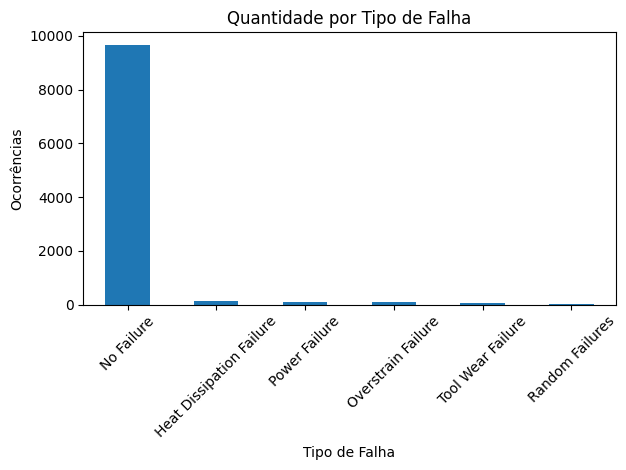

In [ ]:
#Gr√°fico do Tipo de Falhas (apenas para visualiza√ß√£o)

df_dataset['Failure Type'].value_counts().plot(kind='bar')
plt.title('Quantidade por Tipo de Falha')
plt.xlabel('Tipo de Falha')
plt.ylabel('Ocorr√™ncias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Total Falhas x N√£o_Falhas


In [ ]:
# Total de registros no DataFrame
total_registros = len(df_dataset)

# Soma as "No Failure"
total_nao_falhas = falhas[falhas['Tipo de Falha'] == 'No Failure']['Quantidade'].sum()

# Soma apenas as falhas (exclui "No Failure")
total_falhas = falhas[falhas['Tipo de Falha'] != 'No Failure']['Quantidade'].sum()

# Calcula a porcentagem
percentual_nao_falhas = (total_nao_falhas / total_registros) * 100
percentual_falhas = (total_falhas / total_registros) * 100

# Exibe o resultado
print(f"Total de registros.: {total_registros}")
print(f"Total de n√£o falhas: {total_nao_falhas} ou {percentual_nao_falhas:.2f}% do total")
print(f"Total de falhas....: {total_falhas} ou {percentual_falhas:.2f}% do total")


Total de registros.: 10000
Total de n√£o falhas: 9652 ou 96.52% do total
Total de falhas....: 348 ou 3.48% do total


##Pairplot

Esse gr√°fico compara **todas as vari√°veis num√©ricas duas a duas**, usando dispers√£o (scatterplots) e densidade (diagonal). Ele √© segmentado por **tipo de falha (`Failure Type`)**, usando **cores diferentes para cada classe**.

Esse gr√°fico mostra se h√° agrupamentos naturais de pontos (falhas) com base em combina√ß√µes de vari√°veis. Isso pode mostrar, por exemplo, que falhas de "Power Failure" acontecem com baixa rota√ß√£o e alto torque.

### *Eixos:*

* Linhas = vari√°vel no eixo Y
* Colunas = vari√°vel no eixo X
* Diagonal = distribui√ß√£o (densidade) de cada vari√°vel


### *Distribui√ß√µes diagonais (autocorrelacionadas)*

* As curvas mostram a **distribui√ß√£o dos valores por vari√°vel**.
* Por exemplo, a maioria dos valores de `Torque` est√° entre **35 e 55 Nm**, mas com **alguns pontos acima de 70** ‚Üí outliers possivelmente relacionados a falhas.

### *Padr√µes de falha por cor (fora da diagonal)*

| Vari√°veis comparadas          | O que se observa?                                                                                       |
| ----------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Air Temp √ó Process Temp**   | Correla√ß√£o quase perfeita (esperado fisicamente)                                                        |
| **Torque √ó Rotational Speed** | Rela√ß√£o inversa clara (quando torque sobe, rota√ß√£o tende a cair ‚Äî tamb√©m esperado)                      |
| **Torque √ó Failure Type**     | üî• Falhas (especialmente Power Failure e Tool Wear Failure) **concentradas em regi√µes com torque alto** |
| **Tool Wear √ó Torque/Speed**  | Algumas falhas ocorrem com **desgaste elevado e torque alto**                                           |

### *O que chama aten√ß√£o?*

* **Power Failure (laranja)** aparece muito mais em regi√µes com **alta rota√ß√£o** e **alto torque** ‚Üí padr√£o cr√≠tico de opera√ß√£o extrema.
* **Tool Wear Failure (verde)** ocorre em regi√µes de **torque alto + desgaste alto**.
* **Heat Dissipation Failure (roxo)** aparece onde a **temperatura do ar √© mais alta**.
* A classe **"No Failure" (azul)** est√° **muito espalhada**, cobrindo quase todo o gr√°fico ‚Üí normal, pois √© a classe dominante.

Esse gr√°fico mostra como as vari√°veis se comportam em pares e como os diferentes tipos de falha se distribuem nesses espa√ßos. Por exemplo, falhas de desgaste ocorrem quando o torque e o desgaste est√£o altos. J√° falhas de dissipa√ß√£o de calor acontecem quando a temperatura do ar √© maior. Esse tipo de visualiza√ß√£o nos ajuda a entender que tipo de combina√ß√£o de condi√ß√µes pode levar a uma falha.


##Boxplots

Um boxplot (gr√°fico de caixa) **resume a distribui√ß√£o de valores** em cinco partes:

* **Linha central (mediana)**: valor do meio
* **Caixa**: intervalo entre o 1¬∫ quartil (25%) e o 3¬∫ quartil (75%)
* **‚ÄúBigodes‚Äù (linhas finas)**: mostram a faixa de valores dentro de 1,5x a amplitude interquartil (IQR)
* **Pontos fora da caixa** (se houver): s√£o considerados **outliers**

### *O que este gr√°fico mostra?*

Vamos fazer a an√°lise somente para o primeiro gr√°fico. Convido voc√™ a fazer para os demais.

Ele compara a temperatura do ar entre os diferentes **tipos de falha**:

| Tipo de Falha                | Observa√ß√£o sobre Temperatura                                            |
| ---------------------------- | ----------------------------------------------------------------------- |
| **No Failure**               | Mediana \~300K, dispers√£o normal                                        |
| **Power Failure**            | Similar a ‚ÄúNo Failure‚Äù, talvez um pouco mais quente                     |
| **Tool Wear Failure**        | Tamb√©m pr√≥ximo de 300K, sem destaque claro                              |
| **Overstrain Failure**       | Levemente mais fria que as demais                                       |
| **Random Failures**          | Varia mais, tem uma mediana levemente mais alta                         |
| **Heat Dissipation Failure** | üìå **Temperatura claramente mais alta** (\~302‚Äì304K) e mais concentrada |


### Interpreta√ß√£o pr√°tica*

* A temperatura do ar **n√£o varia muito entre os tipos de falha** ‚Äî a maioria fica em torno de **300 K (\~27 ¬∞C)**.
* A exce√ß√£o √© a **Heat Dissipation Failure**, que ocorre com **temperaturas consistentemente mais altas**.

  * Isso faz **sentido f√≠sico**, j√° que o nome indica falha no resfriamento ‚Üí ar mais quente ao redor do sistema.


### *Resultado*

Este gr√°fico mostra que, na maioria dos tipos de falha, a temperatura do ar n√£o muda muito. Mas no caso de falha de dissipa√ß√£o de calor, o ar est√° claramente mais quente. Isso pode indicar que o sistema est√° retendo calor e n√£o est√° conseguindo resfriar direito ‚Äî o que ajuda a entender esse tipo de falha.

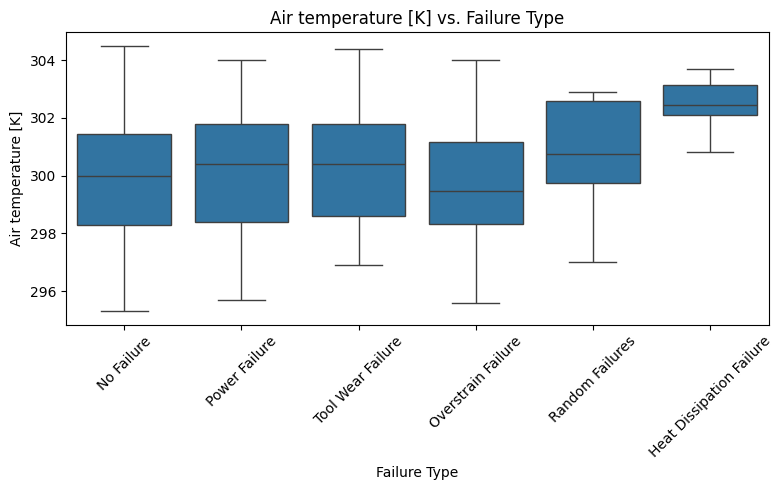

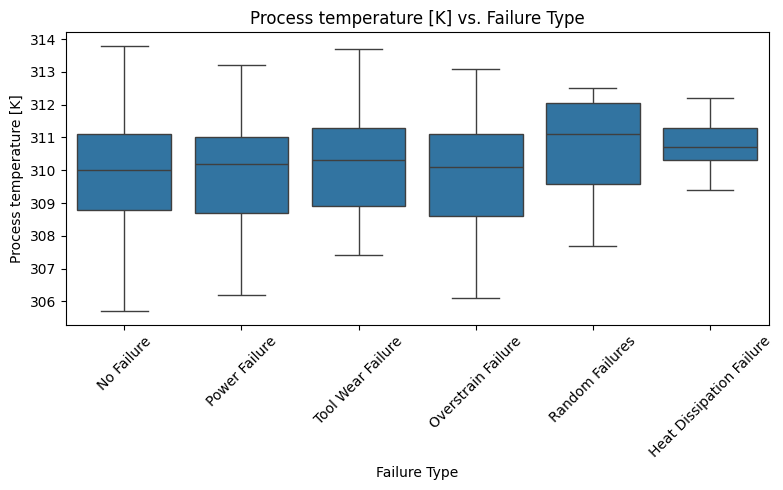

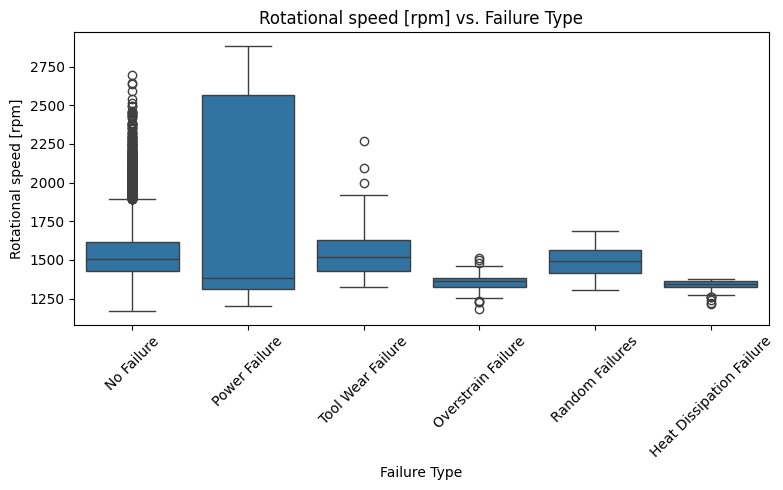

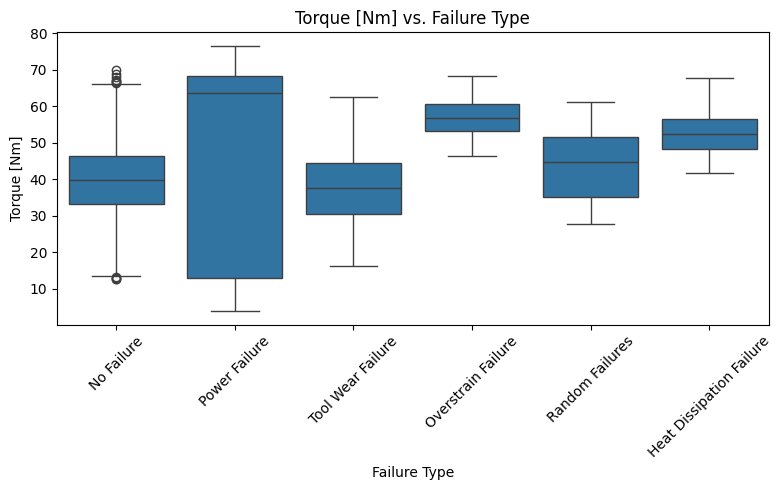

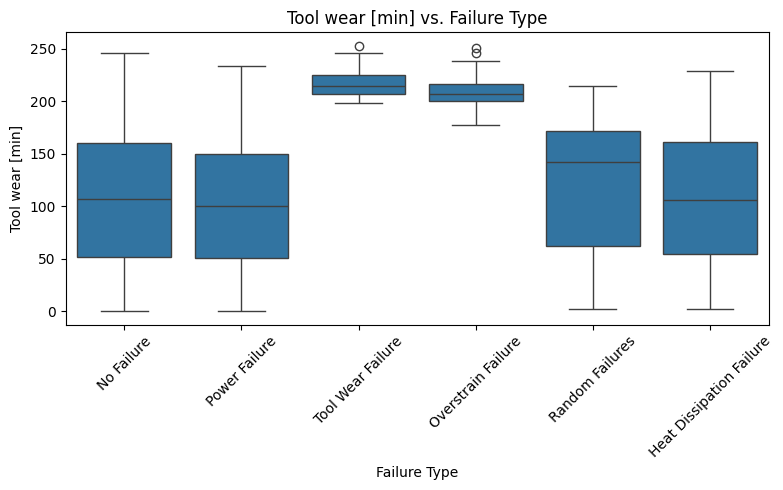

In [ ]:
# Gerar boxplots para cada vari√°vel num√©rica em rela√ß√£o √† vari√°vel categ√≥rica
variaveis = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

for var in variaveis:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_dataset, x='Failure Type', y=var)
    plt.title(f'{var} vs. Failure Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##Histogramas das Vari√°veis Num√©ricas

* O **histograma** (barras) mostra a **frequ√™ncia** de registros em faixas espec√≠ficas de temperatura do ar.
* A **linha azul** representa a **curva de densidade estimada** ‚Äî ela suaviza os dados e mostra como os valores est√£o concentrados.
* O eixo **X** mostra a temperatura do ar em Kelvin.
* O eixo **Y** mostra quantas amostras est√£o em cada faixa de temperatura.

### *Interpreta√ß√£o:*

Vamos fazer para o primeiro. Convido voc√™ a fazer para os demais.

| Observa√ß√£o                                                      | Significado                                                                       |
| --------------------------------------------------------------- | --------------------------------------------------------------------------------- |
| A maior parte dos dados est√° entre **297K e 303K**              | Temperaturas de opera√ß√£o t√≠picas ficam nessa faixa (\~24¬∞C a 30¬∞C)                |
| A distribui√ß√£o tem v√°rios **picos** (multimodal)                | Pode haver grupos de m√°quinas ou momentos distintos de opera√ß√£o                   |
| Existe uma **simetria moderada**, com leve inclina√ß√£o √† direita | Mostra que h√° **alguns casos com temperaturas mais altas**, mas sem grande desvio |

### *Rela√ß√£o com falhas:*

Apesar de ser uma vari√°vel bem distribu√≠da e aparentemente "est√°vel", sabemos por an√°lises anteriores (como boxplots e pairplots) que:

* **Falhas como Heat Dissipation Failure** tendem a ocorrer quando a temperatura do ar est√° **acima de 302K**.
* Isso pode ser confirmado visualmente nesse gr√°fico: a ‚Äúcauda direita‚Äù da curva (temperaturas maiores) √© menos frequente, mas **potencialmente cr√≠tica**.


### *Resultado:*

Este gr√°fico mostra como a temperatura do ar varia. A maioria das medi√ß√µes est√° concentrada perto dos 300K (cerca de 27¬∞C), o que parece ser uma condi√ß√£o normal. Mas h√° alguns casos onde a temperatura √© mais alta, e foi justamente nessas faixas que algumas falhas apareceram, como problemas de dissipa√ß√£o de calor.

#Engenharia de Dados

##Eliminar Valores Nulos
A elimina√ß√£o de valores nulos dever√° ser feita com cuidados. √â necess√°rio avaliar a real necessidade de elimin√°-los, pois h√° alternativas, por exemplo, substituir os valores faltantes pela moda ou pela m√©dia.

In [ ]:
df_dataset.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

N√£o h√° dados nulos

##Eliminar Linhas Duplicadas
J√° sabemos que n√£o h√° duplica√ß√£o, ent√£o, este passo n√£o seria necess√°rio, mas fica a t√≠tulo de exemplo

In [ ]:
# Quantidade total antes
total_antes = len(df_dataset)

# Quantidade de duplicadas
duplicadas = df_dataset.duplicated().sum()

# Remover duplicadas
df_dataset = df_dataset.drop_duplicates()

# Quantidade total depois
total_depois = len(df_dataset)

print(f"Total de linhas antes......................: {total_antes}")
print(f"Linhas duplicadas detectadas...............: {duplicadas}")
print(f"Total de linhas depois do drop_duplicates(): {total_depois}")

Total de linhas antes......................: 10000
Linhas duplicadas detectadas...............: 0
Total de linhas depois do drop_duplicates(): 10000


##Transformar o 'Failure Type' em N√∫mero
A vari√°vel Failure Type √© categ√≥rica, em muitos casos de IA √© necess√°rio converter este tipo de vari√°vel para uma representa√ß√£o num√©rica. Vamos criar uma nova coluna no DF, 'Failure Code', da seguinte correla√ß√£o:
- 'No Failure': 0,
- 'Power Failure': 1
- 'Tool Wear Failure': 2
- 'Overstrain Failure': 3
- 'Random Failures': 4
- 'Heat Dissipation Failure': 5

In [ ]:
# Mapeia os valores √∫nicos da coluna 'Failure Type'
tipos_unicos = df_dataset['Failure Type'].unique()

# Cria um dicion√°rio de mapeamento, garantindo que 'No Failure' seja 0
mapa_falhas = {'No Failure': 0}
codigo = 1
for tipo in tipos_unicos:
    if tipo != 'No Failure':
        mapa_falhas[tipo] = codigo
        codigo += 1

# Aplica o mapeamento
df_dataset['Failure Code'] = df_dataset['Failure Type'].map(mapa_falhas)

In [ ]:
#Exibe a convers√£o feita
print(mapa_falhas)

{'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2, 'Overstrain Failure': 3, 'Random Failures': 4, 'Heat Dissipation Failure': 5}


In [ ]:
#Exibe a cria√ß√£o da coluna Failure_Code no DF
df_dataset.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  \
0                    1551         42.8                0       0   No Failure   
1                    1408         46.3                3       0   No Failure   
2                    1498         49.4                5       0   No Failure   
3                    1433         39.5                7       0   No Failure   
4                    1408         40.0                9       0   No Failure   

   Failure Code  
0             0  
1             0  
2             0  
3             0  
4             0

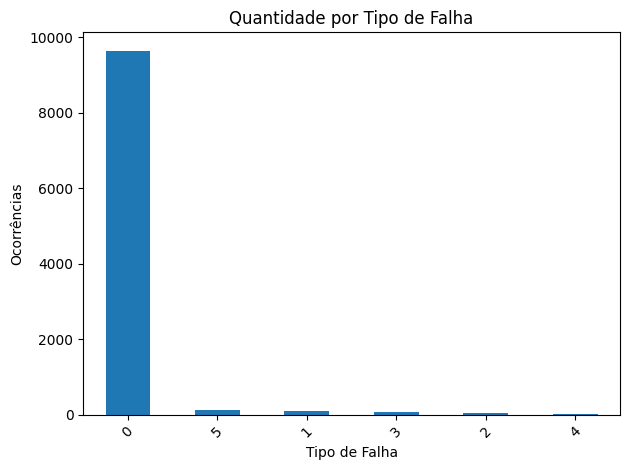

In [ ]:
#Exibe um gr√°fico da quantidade de falhas por 'Failure Code'
df_dataset['Failure Code'].value_counts().plot(kind='bar')
plt.title('Quantidade por Tipo de Falha')
plt.xlabel('Tipo de Falha')
plt.ylabel('Ocorr√™ncias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#An√°lise Explorat√≥ria dos Dados - 2a Parte
N√£o h√° necessidade de repetir os comando da 1a Parte, pois n√£o houve mudan√ßa dos dados (nenhum valor nulo, por exemplo). Ent√£o, vamos aproveitar para fazer mais an√°lises e gr√°ficos

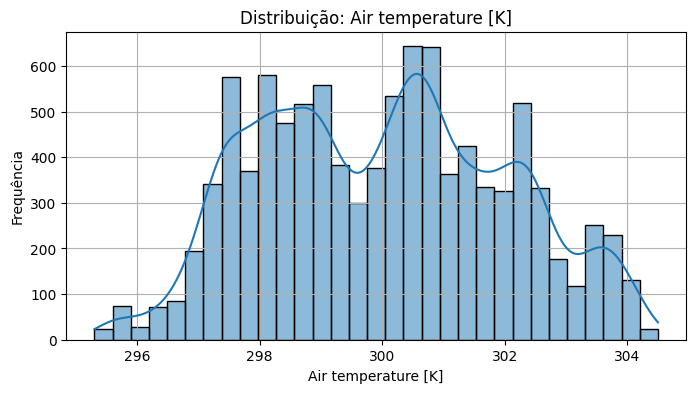

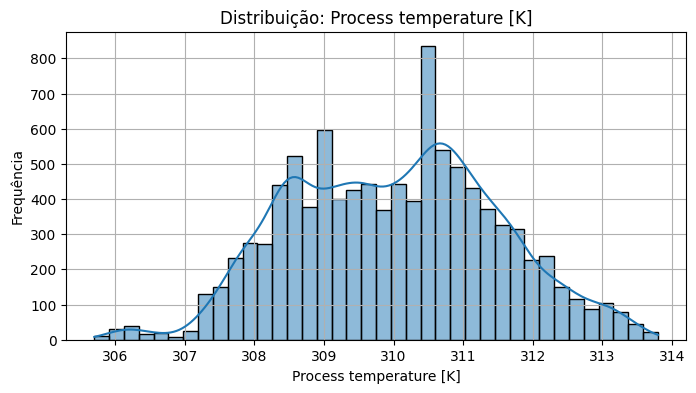

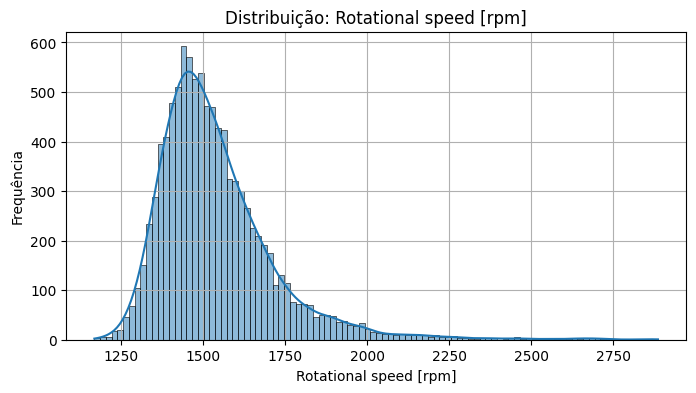

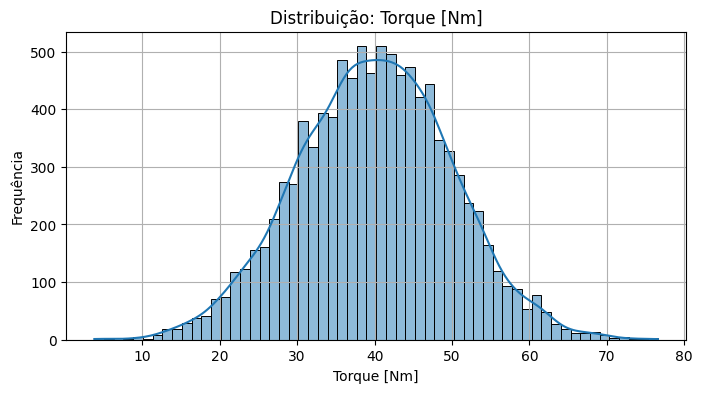

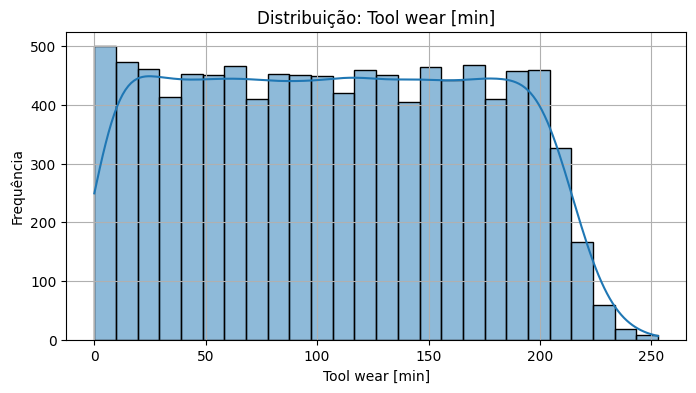

In [ ]:
variaveis = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

for var in variaveis:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_dataset[var], kde=True)
    plt.title(f'Distribui√ß√£o: {var}')
    plt.xlabel(var)
    plt.ylabel("Frequ√™ncia")
    plt.grid(True)
    plt.show()

## Matriz de Correla√ß√£o Completa (Mapa de Calor)

A **matriz de correla√ß√£o de Pearson** mede o **grau de rela√ß√£o linear** entre pares de vari√°veis.

* Valores pr√≥ximos de **1** = rela√ß√£o linear positiva forte
* Valores pr√≥ximos de **‚àí1** = rela√ß√£o linear negativa forte
* Valores pr√≥ximos de **0** = pouca ou nenhuma rela√ß√£o linear

### *Interpreta√ß√£o linha a linha (coluna `Failure_Code`)*

| Vari√°vel                     | Correla√ß√£o com `Failure_Code` | Interpreta√ß√£o pr√°tica                                             |
| ---------------------------- | ----------------------------- | ----------------------------------------------------------------- |
| **Air temperature \[K]**     | ‚àí0.03                         | Praticamente sem rela√ß√£o com o tipo de falha                      |
| **Process temperature \[K]** | ‚àí0.00                         | Nenhuma rela√ß√£o aparente                                          |
| **Rotational speed \[rpm]**  | +0.08                         | Leve tend√™ncia a tipos de falha espec√≠ficos quando a rota√ß√£o muda |
| **Torque \[Nm]**             | +0.03                         | Leve correla√ß√£o (quase irrelevante)                               |
| **Tool wear \[min]**         | +0.11                         | A √∫nica com **correla√ß√£o levemente significativa** com falha      |

üîé **Conclus√£o:** nenhuma vari√°vel tem correla√ß√£o linear forte com o tipo de falha, exceto um leve destaque para `Tool wear`.


### *Correla√ß√µes interessantes entre as vari√°veis (fora do `Failure_Code`)*

| Par de vari√°veis              | Correla√ß√£o | O que isso diz                                                                                                     |
| ----------------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------ |
| **Air temp ‚Üî Process temp**   | +0.88      | Andam juntas ‚Äî provavelmente aumentam ao mesmo tempo                                                               |
| **Torque ‚Üî Rotational speed** | ‚àí0.88      | Rela√ß√£o **fortemente inversa**: quanto mais torque, menor a rota√ß√£o (ou vice-versa) ‚Äî isso faz sentido fisicamente |
| **Outros pares**              | ‚âà 0        | Pouca rela√ß√£o direta entre outras vari√°veis                                                                        |

### *Como isso se conecta √† √°rvore de decis√£o?*

* **Mesmo que a correla√ß√£o seja baixa**, a √°rvore **ainda pode usar essas vari√°veis** para fazer boas divis√µes ‚Äî pois a √°rvore **n√£o depende apenas de rela√ß√µes lineares**.
* Por exemplo:

  * **Torque e Rotational speed** t√™m correla√ß√£o negativa forte entre si, mas **podem ser √∫teis em ramos distintos da √°rvore**.
  * A √°rvore pode usar `Tool wear` como **indicador de falha iminente**, mesmo com correla√ß√£o baixa (porque ela pode fazer um corte inteligente, como "se desgaste > 200 min").


### *Resultado*

Essa matriz mostra que as vari√°veis n√£o t√™m uma rela√ß√£o simples e direta com o tipo de falha. Isso √© normal em problemas complexos como manuten√ß√£o preditiva. A for√ßa da √°rvore de decis√£o est√° justamente em descobrir **regras n√£o lineares** e **combina√ß√µes de vari√°veis** que, juntas, indicam uma falha.

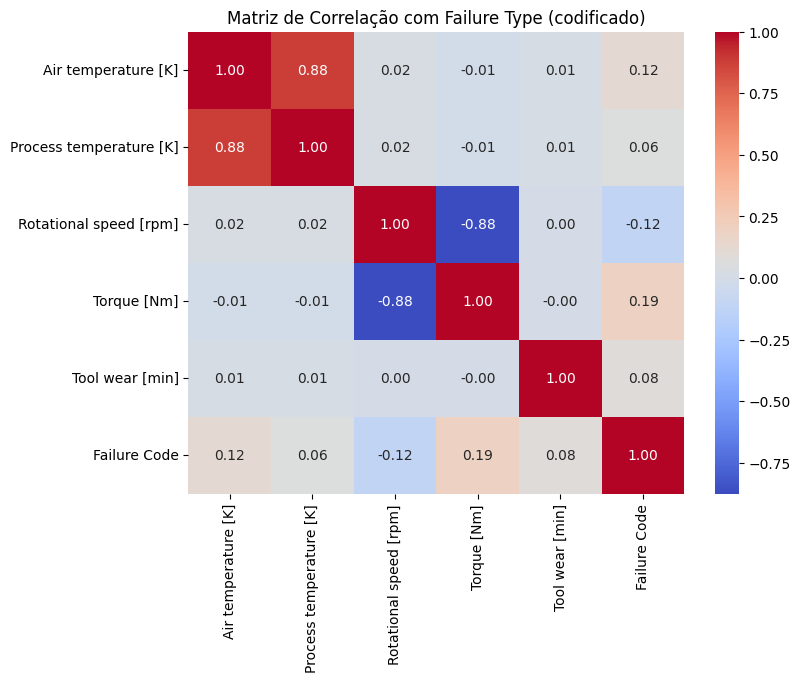

In [ ]:
corr_matrix = df_dataset[variaveis + ['Failure Code']].corr()

# Gerar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correla√ß√£o com Failure Type (codificado)")
plt.show()

##Matriz de Correla√ß√£o entre as Vari√°veis e a Falha

Esse √© um **gr√°fico de barras horizontais** que mostra o **coeficiente de correla√ß√£o** entre cada vari√°vel e o tipo de falha (codificado numericamente).

Mostra a for√ßa e dire√ß√£o de uma rela√ß√£o linear entre cada vari√°vel e a vari√°vel alvo (Failure_Code).

√â global e linear: ele verifica se uma vari√°vel aumenta ou diminui √† medida que o tipo de falha muda (em m√©dia).

Valores pr√≥ximos de zero indicam que a vari√°vel isoladamente n√£o tem uma rela√ß√£o linear forte com a falha.

* **Correla√ß√£o positiva** ‚Üí conforme o valor da vari√°vel aumenta, √© mais prov√°vel que ocorra um certo tipo de falha (classes maiores).
* **Correla√ß√£o negativa** ‚Üí conforme o valor da vari√°vel aumenta, a chance de falha diminui ou muda para outro tipo de falha (classes menores).
* **Pr√≥ximo de zero** ‚Üí pouca ou nenhuma rela√ß√£o linear direta com o tipo de falha.

### *Interpreta√ß√£o do gr√°fico*

| Vari√°vel                | Correla√ß√£o com a falha | Interpreta√ß√£o pr√°tica                                                                      |
| ----------------------- | ---------------------- | ------------------------------------------------------------------------------------------ |
| **Tool wear \[min]**    | **+0.11**              | Quanto mais desgastada a ferramenta, **maior a chance de falha** (forte indicador).        |
| **Torque \[Nm]**        | +0.03                  | Torque alto est√° **levemente associado** a tipos de falhas.                                |
| **Rotational speed**    | ‚âà 0.00                 | **Praticamente sem correla√ß√£o linear** com a falha.                                        |
| **Process temperature** | **‚àí0.01**              | Pequena correla√ß√£o negativa, praticamente irrelevante.                                     |
| **Air temperature**     | **‚àí0.02**              | Um leve ind√≠cio de que temperaturas mais altas do ar podem estar ligadas a falhas menores. |


### *Como interpretar isso?*

* A √∫nica vari√°vel com **correla√ß√£o not√°vel √© `Tool wear`**: isso faz sentido, pois ferramentas muito desgastadas tendem a quebrar ou falhar.
* O restante tem **baixa ou nenhuma correla√ß√£o linear direta**. Isso n√£o significa que s√£o in√∫teis ‚Äî apenas que a rela√ß√£o pode ser **n√£o linear** ou **mais complexa**, e por isso √© melhor capturada por modelos como √°rvores.

### *Resultado*

Esse gr√°fico mostra que, dentre todas as vari√°veis, o desgaste da ferramenta √© o que mais influencia o tipo de falha. Ou seja, quanto mais usada a ferramenta, mais prov√°vel que aconte√ßa uma falha grave. J√° a rota√ß√£o ou a temperatura n√£o t√™m um efeito direto e simples, mas isso n√£o quer dizer que n√£o importam ‚Äî o modelo pode estar captando intera√ß√µes mais complexas entre elas.


Correla√ß√£o com 'Failure Type' codificado:
Air temperature [K]        0.118486
Process temperature [K]    0.055579
Rotational speed [rpm]    -0.119680
Torque [Nm]                0.190346
Tool wear [min]            0.082888
Name: Failure Code, dtype: float64


/tmp/ipython-input-3201224237.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes.values, y=correlacoes.index, orient='h', palette='coolwarm')


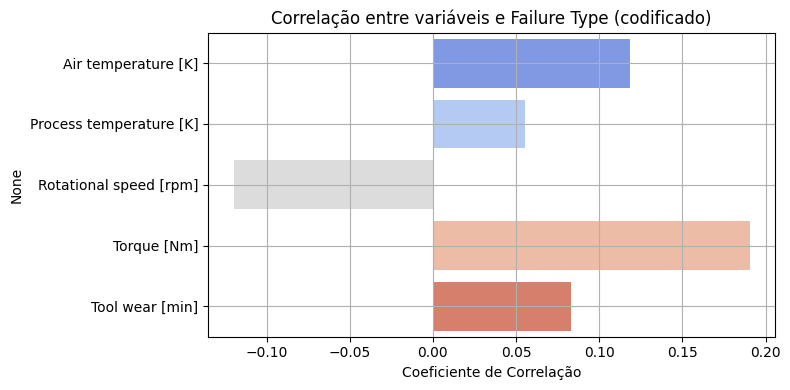

In [ ]:
correlacoes = df_dataset[variaveis + ['Failure Code']].corr()['Failure Code'].drop('Failure Code')

# Exibir os resultados
print("Correla√ß√£o com 'Failure Type' codificado:")
print(correlacoes)

plt.figure(figsize=(8, 4))
sns.barplot(x=correlacoes.values, y=correlacoes.index, orient='h', palette='coolwarm')
plt.title("Correla√ß√£o entre vari√°veis e Failure Type (codificado)")
plt.xlabel("Coeficiente de Correla√ß√£o")
plt.grid(True)
plt.tight_layout()
plt.show()

#Treinamento da IA

##Escolha das Features e do Target
Seleciona as colunas de entrada (chamadas de features), ou seja, os dados que o modelo vai usar para tentar aprender.

Seleciona a coluna alvo (Failure_Code) que √© o que o modelo tentar√° prever.

In [ ]:
features = df_dataset[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
target = df_dataset[['Failure Code']]

In [ ]:
features.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  
0         42.8                0  
1         46.3                3  
2         49.4                5  
3         39.5                7  
4         40.0                9

##Separa√ß√£o dos Dados em Aprendizado e Teste

Divide o conjunto de dados em 80% para treinar e 20% para testar o modelo. Isso √© feito para avaliar se o modelo est√° aprendendo bem ou apenas decorando os dados.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

##Normaliza√ß√£o
N√£o ser√° feita a normaliza√ß√£o neste exemplo. Fica aqui o desafio para que voc√™ possa faz√™-lo.

##Parametrizar o Modelo RandomForestClassifier

√â um modelo de **classifica√ß√£o** baseado em **v√°rias √°rvores de decis√£o**. Ele funciona como um ‚Äúconselho de especialistas‚Äù: cada √°rvore d√° um palpite e a floresta vota na melhor resposta.

Aqui estamos criando uma floresta com 100 √°rvores, limitando cada uma para que n√£o fique muito profunda (10 n√≠veis no m√°ximo). Tamb√©m estamos controlando quando ela pode dividir os dados e o n√∫mero m√≠nimo de exemplos que devem existir em cada divis√£o. Esses par√¢metros ajudam a equilibrar o aprendizado para que o modelo n√£o fique nem muito simples, nem muito detalhista a ponto de decorar os dados.


#### An√°lise detalhada dos hiperpar√¢metros


| Par√¢metro                 | Explica√ß√£o simples                                                             | Impacto no modelo                                                                        |
| ------------------------- | ------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------- |
| **n\_estimators=100**     | N√∫mero de √°rvores na floresta.                                                 | Mais √°rvores = maior robustez, mas tamb√©m mais lento. 100 √© um valor t√≠pico.             |
| **max\_depth=10**         | Limita a profundidade de cada √°rvore (quantos n√≠veis de decis√£o pode ter).     | Evita √°rvores muito profundas (e complexas), que podem ‚Äúdecorar‚Äù os dados (overfitting). |
| **min\_samples\_split=2** | N√∫mero m√≠nimo de amostras para que um n√≥ seja dividido.                        | Quanto maior, mais conservadora a √°rvore (menos splits).                                 |
| **min\_samples\_leaf=1**  | N√∫mero m√≠nimo de amostras que devem existir em cada folha (fim de uma √°rvore). | Impede que o modelo crie folhas com 1 √∫nico exemplo (o que pode causar overfitting).     |
| **random\_state=42**      | Define uma semente para gera√ß√£o aleat√≥ria.                                     | Garante que voc√™ tenha os **mesmos resultados sempre que rodar o c√≥digo**.               |

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = RandomForestClassifier(
    n_estimators=100,        # n√∫mero de √°rvores
    max_depth=10,            # profundidade m√°xima
    min_samples_split=2,     # m√≠nimo de amostras para split
    min_samples_leaf=1,      # m√≠nimo de amostras por folha
    random_state=42
)

##Treinamento
fit() ‚Üí ensina o modelo a fazer previs√µes com os dados de treino.

In [ ]:
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=10, random_state=42)

#Avalia√ß√£o do Modelo

## Prever
predict() ‚Üí o modelo usa o que aprendeu para prever os resultados do conjunto de teste.

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 1 0]


##Avaliar Desempenho do Modelo

In [ ]:
print("Acur√°cia:", accuracy_score(y_test, y_pred))
print("\nRelat√≥rio de Classifica√ß√£o:\n", classification_report(y_test, y_pred))

Acur√°cia: 0.9805

Relat√≥rio de Classifica√ß√£o:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1935
           1       0.83      0.75      0.79        20
           2       0.00      0.00      0.00        11
           3       0.80      0.62      0.70        13
           4       0.00      0.00      0.00         6
           5       0.89      0.53      0.67        15

    accuracy                           0.98      2000
   macro avg       0.58      0.48      0.52      2000
weighted avg       0.97      0.98      0.98      2000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


√â uma avalia√ß√£o detalhada do desempenho do modelo para **cada classe** (tipo de falha).
Ele mostra **3 m√©tricas principais** para cada classe:

| M√©trica       | Significado Pr√°tico                                                                        |
| ------------- | ------------------------------------------------------------------------------------------ |
| **Precision** | De todas as vezes que o modelo disse que era aquela classe, quantas estavam corretas?      |
| **Recall**    | De todas as vezes que realmente era aquela classe, quantas o modelo detectou?              |
| **F1-score**  | Equil√≠brio entre precision e recall (muito usada quando h√° desequil√≠brio entre as classes) |
| **Support**   | Quantidade real de exemplos dessa classe no conjunto de teste                              |


### *Interpreta√ß√£o por Classe*

| Classe | Precision | Recall | F1-score | Support | Interpreta√ß√£o                                                                                       |
| ------ | --------- | ------ | -------- | ------- | --------------------------------------------------------------------------------------------------- |
| **0**  | 0.98      | 0.53   | 0.67     | 15      | Excelente ‚Äî acerta quase sempre (normal, pois √© a classe dominante)
| **1**  | 0.83      | 1.00   | 0.99     | 1935    | Razo√°vel, mas perde alguns casos reais                                |
| **2**  | 0.00      | 0.62   | 0.70     | 13      | ‚ö†Ô∏è O modelo **nunca acerta essa classe**                                                              |
| **3**  | 0.80      | 0.75   | 0.79     | 20      | Tamb√©m bom, mas ainda h√° falhas                                                                     |
| **4**  | 0.00      | 0.00   | 0.00     | 6       | ‚ö†Ô∏è Mesmo problema da classe 2 ‚Äî **n√£o foi detectada nenhuma vez**   
| **5**  | 0.89      | 0.00   | 0.00     | 11      | O modelo acerta bem quando diz que √© classe 5


### *M√©tricas gerais (finais da tabela)*

| M√©trica          | Valor              | Significado                                                               |
| ---------------- | ------------------ | ------------------------------------------------------------------------- |
| **accuracy**     | 0.98 | O modelo acerta **98% das previs√µes** no total                            |
| **macro avg**    | 0.58 / 0.48 / 0.52 | M√©dia simples entre as classes (sem considerar o desequil√≠brio)           |
| **weighted avg** | 0.97 / 0.98 / 0.98 | M√©dia ponderada (mais justa se a classe 1 tem muitos exemplos, como aqui) |



### *O que isso quer dizer?*

* O modelo **√© √≥timo para a classe 0**, que √© a **mais comum** (normalmente, ‚Äúsem falha‚Äù).
* Mas **ignora completamente as classes 2 e 4**, o que pode ser **cr√≠tico** se essas forem falhas importantes.
* Isso √© um caso cl√°ssico de **desequil√≠brio de classes**: o modelo foca demais na classe majorit√°ria.

### *Resultado*

Mesmo com uma acur√°cia de 98%, o modelo n√£o √© bom em detectar todas as falhas. Ele acerta bem os casos normais, mas falha totalmente nas classes menos frequentes. Isso mostra que a acur√°cia sozinha n√£o √© suficiente. Precisamos olhar tamb√©m o f1-score e o recall das classes de falha.

### *Pr√≥ximos passos recomendados (fica como sugest√£o)*

1. **Balancear as classes** com:

   * T√©cnicas como **SMOTE** ou **undersampling**
   * Treinamento com `class_weight='balanced'`

2. **Avaliar o modelo com macro F1-score**, para valorizar as classes pequenas.

3. **Gerar mais exemplos das classes 2 e 4**, se poss√≠vel.
Se quiser, posso gerar um c√≥digo para balancear os dados e reavaliar o modelo. Deseja isso?

## Gerar a Matriz de Confus√£o

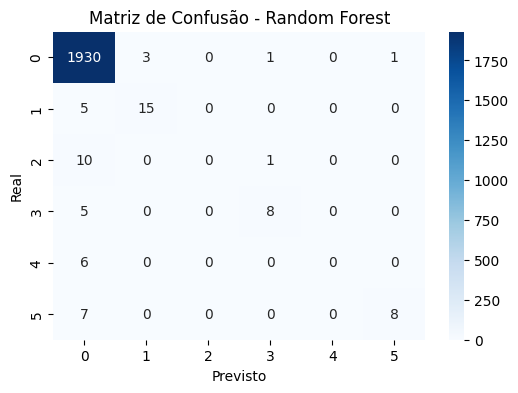

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confus√£o - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

A matriz de confus√£o mostra onde o modelo acerta e onde se engana. Aqui, o modelo √© excelente para prever a classe 1 (mais comum), mas n√£o est√° conseguindo identificar bem as falhas das classes 2 e 4. Isso pode acontecer por falta de dados dessas falhas ou porque elas s√£o muito parecidas com situa√ß√µes normais. O pr√≥ximo passo seria reequilibrar os dados e tentar entender melhor esses erros.

√â uma tabela que compara os **valores reais** com os **valores previstos** pelo modelo.
Ela mostra **onde o modelo acertou** (diagonal principal) e **onde errou** (fora da diagonal).

√â uma tabela que mostra onde o modelo acertou e errou.

- Linhas ‚Üí valores reais

- Colunas ‚Üí valores previstos

### *Interpreta√ß√£o do gr√°fico*

- A diagonal principal (de cima √† esquerda at√© baixo √† direita) mostra os acertos.

- Valores fora da diagonal mostram erros, indicando em que o modelo se confundiu.

Essa matriz tem **6 classes** (de 0 a 5), representando c√≥digos de falhas (ex: `Failure_Code`).
Aqui est√° o que vemos:

| Classe Real  | Acertos (diagonal) | Erros (previs√µes incorretas) | Observa√ß√µes                                                   |
| ------------ | ------------------ | ---------------------------- | ------------------------------------------------------------- |
| **Classe 0** | 1930               | 1 como 0, 1 como 2, 3 como 3 | üî• Modelo vai muito bem nessa classe                          |
| **Classe 1** | 15                 | 5 como 1                     | Confus√£o moderada                                             |
| **Classe 2** | 0                  | 10 como 0, 1 como 3          | ‚ö†Ô∏è Outro problema grave: o modelo **nunca acerta a classe 2** |
| **Classe 3** | 8                  | 5 como 0                     | Poucos erros                                                  |
| **Classe 4** | 0                  | 6 como 0                     | ‚ö†Ô∏è Modelo **n√£o acerta nenhum exemplo** da classe 4           |
| **Classe 5** | 8                  | 7 preditos como 0            | Modelo est√° confuso entre 0 e 5                               |


### *O que isso nos diz?*

1. **Classe 1 domina o dataset** (1930 exemplos corretos)
   ‚Üí Isso √© comum em dados industriais onde a maioria dos registros s√£o de opera√ß√£o normal (sem falha).

2. **Classe 0 tem poucos exemplos e o modelo confunde com classe 1**
   ‚Üí Talvez falhas da classe 0 tenham caracter√≠sticas parecidas com opera√ß√£o normal.

3. **Classe 4 e 5 n√£o s√£o reconhecidas corretamente**
   ‚Üí Isso pode indicar:

   * Dados desbalanceados (poucos exemplos dessas classes).
   * As features n√£o conseguem distinguir bem essas falhas.
   * Modelo precisa de ajuste ou dados mais representativos.

### *O que fazer a seguir? (fica como sugest√£o)*

#### 1. Balancear as classes

* Use t√©cnicas como **SMOTE**, **undersampling** ou **class\_weight='balanced'** para treinar o modelo com mais equil√≠brio.

#### 2. Analisar casos da classe 2 e 4

* Investigue por que o modelo erra sempre essas classes. Talvez os exemplos estejam mal rotulados, ou com valores muito parecidos aos de outra classe.

#### 3. An√°lise com SHAP ou LIME

* Use explicadores para ver o que o modelo est√° "pensando" nesses erros.

##Descrever a Import√¢ncia Relativa de Cada Vari√°vel

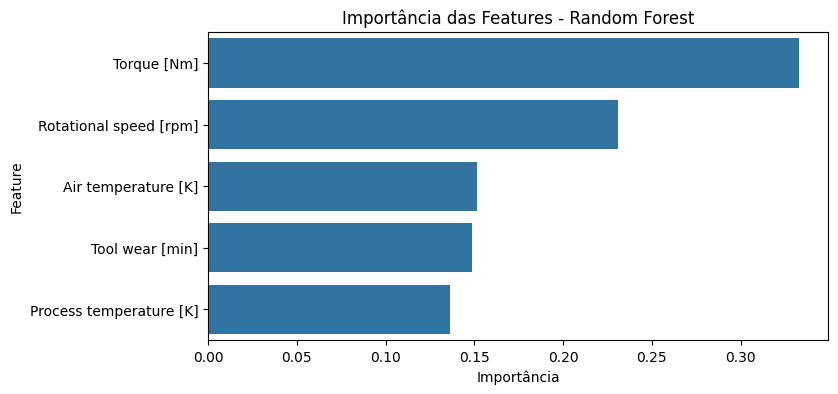

In [ ]:
importancias = model.feature_importances_
feature_names = features.columns
importancia_df = pd.DataFrame({'Feature': feature_names, 'Import√¢ncia': importancias})
importancia_df = importancia_df.sort_values(by='Import√¢ncia', ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(data=importancia_df, x='Import√¢ncia', y='Feature')
plt.title('Import√¢ncia das Features - Random Forest')
plt.show()

A **import√¢ncia de uma feature** em um modelo de √°rvore como o Random Forest representa o **quanto aquela vari√°vel ajudou o modelo a tomar decis√µes corretas**. √â baseada na **redu√ß√£o da impureza (gini)** nas divis√µes da √°rvore.

> Quanto mais uma vari√°vel aparece nos n√≥s superiores das √°rvores, e quanto mais ela ajuda a separar os dados corretamente, maior sua import√¢ncia.

Esse gr√°fico mostra quais vari√°veis o modelo considera mais importantes para prever o tipo de falha. Por exemplo, ele descobriu que o torque do motor √© o fator mais decisivo. Isso pode indicar que motores for√ßados demais t√™m mais chance de gerar falhas. J√° a temperatura do processo teve pouca influ√™ncia, talvez por ser mais est√°vel ou menos relacionada √†s falhas que queremos prever.


### *Interpreta√ß√£o do Gr√°fico*

Aqui est√£o as vari√°veis, ordenadas da mais importante para a menos importante:

| Vari√°vel                     | Interpreta√ß√£o                                                                                                                      |
| ---------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| **Torque \[Nm]**             | ‚úÖ A vari√°vel **mais decisiva**. Diferen√ßas no torque s√£o fortemente associadas √† ocorr√™ncia de falhas.                             |
| **Rotational speed \[rpm]**  | üõ†Ô∏è Tamb√©m muito relevante. Altera√ß√µes na rota√ß√£o est√£o correlacionadas a falhas espec√≠ficas.                                      |
| **Air temperature \[K]**     | üå°Ô∏è Temperatura do ar tem impacto, mas √© menos decisiva sozinha.                                                                   |
| **Tool wear \[min]**         | üîß Embora desgaste da ferramenta cause falhas, ele pode ser previsto indiretamente via torque.                                     |
| **Process temperature \[K]** | üßä A vari√°vel **menos usada** nas decis√µes das √°rvores. Pode indicar que seu valor varia pouco ou √© redundante com outra vari√°vel. |


### *O que voc√™ pode fazer com isso?*

* Focar sensores ou monitoramento em vari√°veis mais importantes (como Torque).
* Reduzir vari√°veis em modelos futuros, eliminando as menos relevantes.

##Visualizar a √Årvore

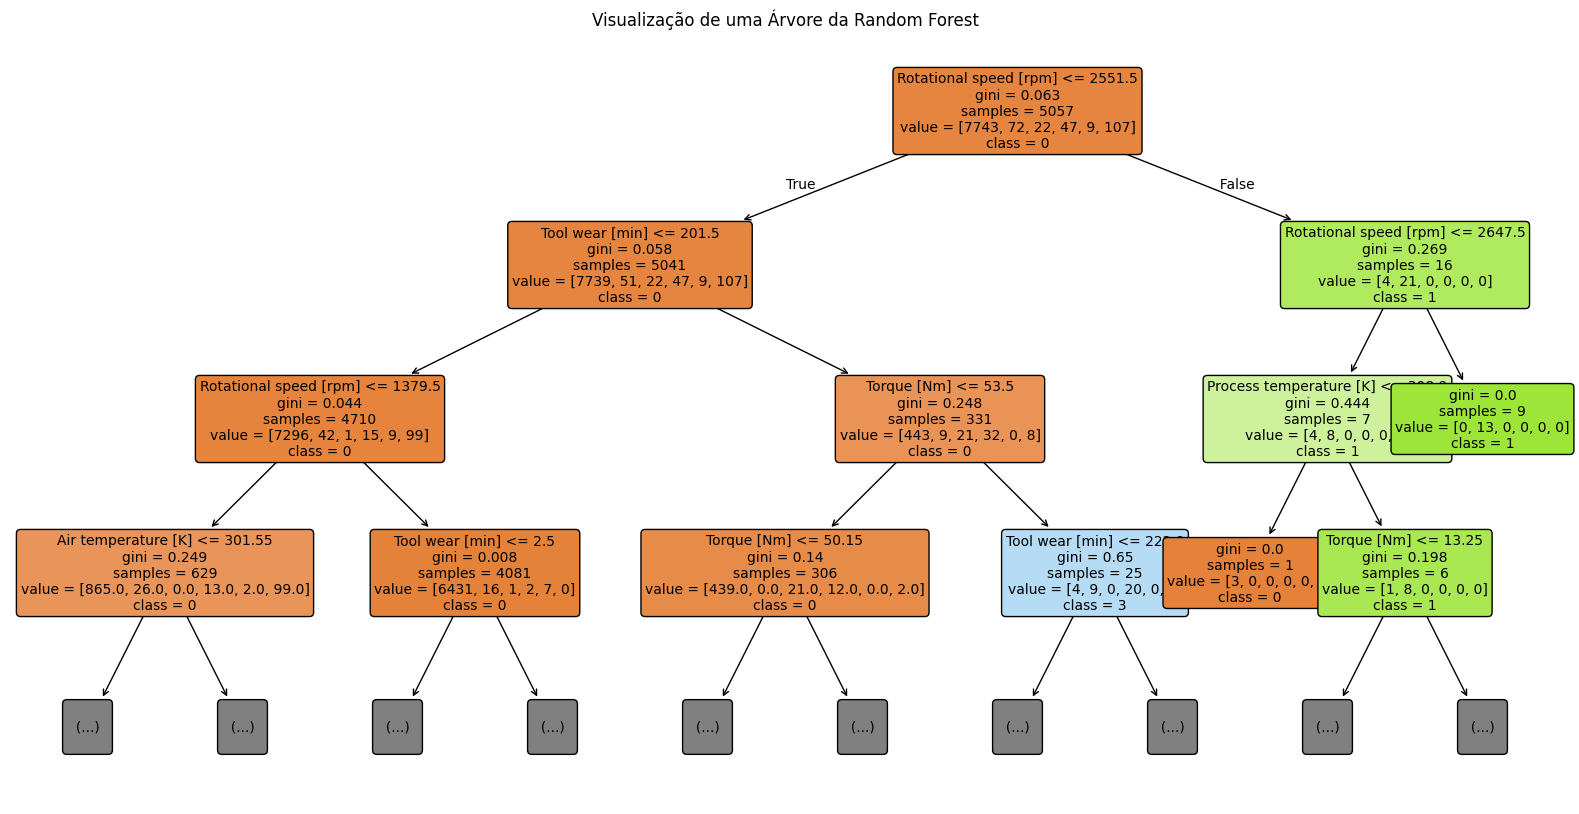

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Seleciona a primeira √°rvore da floresta
arvore = model.estimators_[0]

# Plotar a √°rvore
plt.figure(figsize=(20, 10))
plot_tree(arvore,
          feature_names=features.columns,
          class_names=[str(c) for c in np.unique(target.values.ravel())],
          filled=True,
          rounded=True,
          max_depth=3,  # limitar a profundidade para facilitar a leitura
          fontsize=10)
plt.title("Visualiza√ß√£o de uma √Årvore da Random Forest")
plt.show()

Mostra como o modelo usa cada vari√°vel para dividir os dados e tomar decis√µes.

√â n√£o linear, condicional e hier√°rquica.

Mesmo uma vari√°vel com baixa correla√ß√£o linear pode ser muito √∫til na √°rvore quando combinada com outras condi√ß√µes.


A √°rvore mostra as regras que o modelo aprendeu para prever falhas. Por exemplo, se a rota√ß√£o for baixa e o desgaste n√£o for extremo, o modelo conclui que n√£o h√° falha. Mas se a rota√ß√£o for muito alta e o torque muito baixo, pode indicar uma falha espec√≠fica. Cada divis√£o representa uma condi√ß√£o de opera√ß√£o, e o modelo aprende com os dados hist√≥ricos onde os problemas costumam surgir.



* Mostra graficamente uma das √°rvores da floresta (Random Forest).

* Ajuda a entender como as decis√µes s√£o tomadas com base nas vari√°veis.

* max_depth=3 ‚Üí mostra s√≥ os 3 primeiros n√≠veis para facilitar a visualiza√ß√£o.

### *Interpreta√ß√£o do Gr√°fico*

Cada **caixa verde ou azul** √© uma **decis√£o baseada em uma vari√°vel**, como:

* `Rotational speed [rpm] <= 2551.5`
* `Tool wear [min] <= 201.5`
* `Torque [Nm] <= 53.5`

Essas condi√ß√µes **dividem os dados** em subconjuntos cada vez mais homog√™neos, at√© que se chegue a uma **classe** (falha prevista).

* Os **n√≥s verdes** indicam que a **classe 1 (provavelmente ‚Äúsem falha‚Äù)** √© a mais comum.

* **N√≥s azuis** geralmente indicam previs√µes de **falhas reais** (classes ‚â† 1).

### *Como interpretar as informa√ß√µes de cada n√≥*

Por exemplo:

```text
Rotational speed [rpm] <= 2551.5
gini = 0.063
samples = 5057
value = [107, 7743, 47, 72, 9, 22]
class = 1
```

* `Rotational speed [rpm] <= 2551.5`: √â o crit√©rio de divis√£o (se verdadeiro, v√° √† esquerda; se falso, v√° √† direita).
* `gini`: Quanto mais pr√≥ximo de 0, mais puro o grupo (s√≥ uma classe).
* `samples`: N√∫mero de amostras que chegaram at√© aqui.
* `value = [...]`: Contagem de exemplos de cada classe (por exemplo, `[classe_0, classe_1, ..., classe_5]`)
* `class = 1`: Classe mais comum naquele grupo (classe prevista).

### *Raiz (n√≥ principal)*

```text
Rotational speed [rpm] <= 2551.5
```

* Se a rota√ß√£o for **menor ou igual a 2551.5 rpm**, v√° para a **esquerda** (maioria dos casos).
* Se **maior**, v√° para a **direita** (casos raros).

### *Lado Esquerdo: onde a maioria dos dados est√°*

1. **Tool wear \[min] <= 201.5**
   M√°quinas com **desgaste da ferramenta menor** que 201.5 minutos seguem √† esquerda.

2. Depois, a √°rvore analisa o **torque**, a **rota√ß√£o** e at√© a **temperatura** para refinar se √© falha ou n√£o.

* A √°rvore descobriu que **baixa rota√ß√£o + desgaste moderado + torque controlado** quase sempre indicam que n√£o h√° falha.

### *Lado Direito: casos raros e mais variados*

* Aqui, a **rota√ß√£o √© muito alta (> 2551.5 rpm)**, o que √© incomum.
* Ainda assim, vemos que:

  * Para `Rotational speed > 2647.5`, e dependendo da `Process temperature` ou `Torque`, o modelo prev√™ falhas das classes 2 e 3.
  * Exemplo: se `Torque <= 13.25`, ent√£o a classe prevista √© **classe 3** (provavelmente "Tool Wear Failure" ou similar).


### *Resultado*

* A maioria das condi√ß√µes leva √† **classe 1** ‚Üí ou seja, o sistema opera normalmente na maioria dos casos.
* **Desgaste elevado**, **torque fora do comum** e **rota√ß√£o extrema** s√£o condi√ß√µes que **aumentam a probabilidade de falha**.
* Algumas **falhas espec√≠ficas aparecem em contextos bem delimitados**, como `Torque <= 13.25` ou `Tool wear <= 22`.





#Utiliza√ß√£o do Modelo
Agora que j√° treinamos e testamos a IA, vamos utiliz√°-la para prever situa√ß√µes reais. Para isso vamos criar um DataFrame com os seguintes dados:
- 'Air temperature [K]': [300]
- 'Process temperature [K]': [310]
- 'Rotational speed [rpm]': [1600]
- 'Torque [Nm]': [55]
- 'Tool wear [min]': [100]

Isso n√£o deve provocar falhas. Mas se voc√™ quiser simular uma falha, alterer o 'Rotational speed' parar 2600, pois j√° descobrimos que valores acima de 2551,5 (conforme dados do gr√°fico da √°rvore) s√£o bastante proponsos a falhas; e simule movamente a partir desse ponto (n√£o precisa executar tudo de novo)




## Criar um DataFrame com os Dados Fict√≠cios

In [ ]:
df_simulacao = pd.DataFrame({
    'Air temperature [K]': [300],
    'Process temperature [K]': [310],
    'Rotational speed [rpm]': [2600],
    'Torque [Nm]': [55],
    'Tool wear [min]': [100],
})
df_simulacao.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                  300                      310                    2600   

   Torque [Nm]  Tool wear [min]  
0           55              100

##Prever Resultados

In [ ]:
# Seleciona a linha de entrada (uma linha qualquer do DataFrame acima, entre 0 e 4)
linha = df_simulacao.iloc[[0]]

# Faz a previs√£o
previsao = model.predict(linha)[0]

# Exibe os dados de entrada de forma formatada
print("üìå Dados da Simula√ß√£o:")
print(df_simulacao.iloc[0].to_frame().T.to_string(index=False))
print()

# Exibe o resultado de forma clara
if previsao == 0:
    print("üü¢ Resultado da Previs√£o: SEM falha.")
elif previsao == 1:
    print("üî¥ Resultado da Previs√£o: FALHA detectada --> Power Failure.")
elif previsao == 2:
    print("üî¥ Resultado da Previs√£o: FALHA detectada --> Tool Wear Failure.")
elif previsao == 3:
    print("üî¥ Resultado da Previs√£o: FALHA detectada --> Overstrain Failure.")
elif previsao == 4:
    print("üî¥ Resultado da Previs√£o: FALHA detectada --> Random Failures.")
elif previsao == 5:
    print("üî¥ Resultado da Previs√£o: FALHA detectada --> Heat Dissipation Failure.")

üìå Dados da Simula√ß√£o:
 Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]
                 300                      310                    2600           55              100

üî¥ Resultado da Previs√£o: FALHA detectada --> Power Failure.


##Explicar o Resultado da Previs√£o
Ser√£o exibidos os c√°lculos feitos durantes a previs√£o

In [ ]:
explainer = shap.Explainer(model)  # Detecta o tipo de modelo

# Calcula a explica√ß√£o
shap_values = explainer(linha)
print(f"Dimen√ß√£o de Shap values:", shap_values.shape)
print(f"Shap values:", shap_values)

Dimen√ß√£o de Shap values: (1, 5, 6)
Shap values: .values =
array([[[-4.22770862e-03,  1.77266461e-02, -2.20096592e-04,
          3.30997911e-04,  1.32824778e-04, -1.37426636e-02],
        [-1.13246345e-02,  4.81689512e-03, -1.62791468e-03,
          7.10260148e-05, -2.96140525e-04,  8.36076861e-03],
        [-5.06553780e-01,  5.26468725e-01,  2.04296450e-03,
         -6.40813092e-03, -1.40832054e-03, -1.41414573e-02],
        [ 3.40034861e-02, -5.66780439e-02,  9.44641332e-04,
          1.24030380e-02,  9.28039159e-04,  8.39883922e-03],
        [ 1.25776435e-02,  8.38004627e-03, -5.43960440e-03,
         -1.45459948e-02, -7.16036787e-05, -9.00486929e-04]]])

.base_values =
array([[0.964595  , 0.0093875 , 0.0043175 , 0.00815125, 0.00152375,
        0.012025  ]])

.data =
array([[ 300,  310, 2600,   55,  100]])


## Visualizar o Resultado da Previs√£o

Ser√° exbido um gr√°fico que explica as decis√µes tomadas para a classifica√ß√£o em "FALHA" ou "SEM falha". O gr√°fico explica como cada vari√°vel contribuiu para a previs√£o do tipo de erro

In [ ]:
# Initialize JavaScript for SHAP plots
shap.initjs()
shap.plots.force(
    explainer.expected_value[0],
    shap_values.values[0],
    feature_names=linha.columns)

## Interpretar o Gr√°fico
O cruzamento do eixo X com o eixo Y indicado o quanto cada vari√°vel contribui para a falha.

**Eixo X**: Cada n√∫mero representa um tipo de erro:
- 'No Failure': 0,
- 'Power Failure': 1
- 'Tool Wear Failure': 2
- 'Overstrain Failure': 3
- 'Random Failures': 4
- 'Heat Dissipation Failure': 5

Deve-se ignorar os valores quebrados (0.5).

**Eixo Y**: * Mostra os efeitos acumulados de cada vari√°vel.
Pode-se ecolher um vari√°vel espec√≠fica ou todas ao mesmo tempo f(x).

* üîµ **√Åreas azuis**: vari√°veis que **puxaram a previs√£o para baixo**, ou seja, contra a classe de interesse (ex: "sem falha")

* üî¥ **√Åreas vermelhas**: vari√°veis que **puxaram a previs√£o para cima**, ou seja, a favor da classe de interesse (ex: "falha")

* A base (meio) come√ßa no **valor esperado (`expected_value`)**, que representa a m√©dia de sa√≠da do modelo. serve como ponto de partida para a explica√ß√£o. Est√° no centro e representa a predi√ß√£o m√©dia do modelo (ex: probabilidade m√©dia de falha).

* O **ponto final** (canto direito) √© o valor predito pelo modelo para esta inst√¢ncia

Se o resultado final foi falha, √© porque a **soma das for√ßas vermelhas foi maior que a das azuis**, levando a predi√ß√£o final a ultrapassar o limiar.


#Considera√ß√µes Finais

Notou-se que o modelo possui problemas na classifica√ß√£o dos tipos de falha 2 e 4. Isso pode requerer ajustes no modelo.

**Deasafio**: voc√™ seria capaz de melhor√°-lo?

#Fim